In [1]:
#ignore if not windows
import winsound

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import helper

In [144]:
nominal_sample = pd.read_csv('samples/2015_nominal_samples_n1.csv')
gray_sample = pd.read_csv('samples/2015_gray_samples_n1.csv')
failure_sample = pd.read_csv('samples/2015_failure_samples_n1.csv')

In [145]:
nominal_sample = nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
failure_sample = failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample    = gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample.failure = 1
nominal_sample = nominal_sample.sample(frac=(failure_sample.shape[0]+gray_sample.shape[0])/nominal_sample.shape[0])
data_curr = pd.concat([nominal_sample, failure_sample, gray_sample])
data_curr = data_curr.sample(frac=1)

In [204]:
#normalized
feature_columns = [ 'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
           'smart_7_normalized','smart_12_normalized', 'smart_194_normalized', 
           'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']

In [194]:
#raw
#feature_columns = [ 'smart_1_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw',
#           'smart_7_raw','smart_12_raw', 'smart_194_raw', 
#           'smart_197_raw', 'smart_198_raw', 'smart_199_raw']

In [205]:
scale = 'sk'
train_size = .66

if scale=='sk':
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
elif scale=='sk_manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)

    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        
        scaler = StandardScaler()
        data_sub = scaler.fit_transform(data_sub[feature_columns])
        test_sub = scaler.transform(test_sub[feature_columns])
        
        train_norm = pd.concat([train_norm,pd.DataFrame(data_sub)])
        test_norm = pd.concat([test_norm,pd.DataFrame(test_sub)])
        
        
    x_train = train_norm.sample(frac=1)#[feature_columns]
    x_val = test_norm.sample(frac=1)#[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
elif scale=='manu_global':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)
    
    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:    
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        max_ = pd.read_csv('scaling/%s_max.csv' % man.lower())
        max_.index = max_['date']
        del max_['date']
        max_.columns = ['value']
        min_ = pd.read_csv('scaling/%s_min.csv' % man.lower())
        min_.index = min_['date']
        del min_['date']
        min_.columns = ['value']
        for col in feature_columns:
            range_ = float(max_.value[col]) - float(min_.value[col])
            if range_==0:
                range_ = 1
            data_sub[col] = (data_sub[col] - float(min_.value[col]))/range_
            test_sub[col] = (test_sub[col] - float(min_.value[col]))/range_
        train_norm = pd.concat([train_norm,data_sub])
        test_norm = pd.concat([test_norm,test_sub])
        
    x_train = train_norm.sample(frac=1)[feature_columns]
    x_val = test_norm.sample(frac=1)[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
    
else:
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [206]:
# *** MODELS ***
lr1 = LogisticRegression(solver='newton-cg')
lr2 = LogisticRegression(solver='lbfgs')
lr3 = LogisticRegression(solver='saga')
lr4 = LogisticRegression(solver='sag')
lr5 = LogisticRegression(solver='liblinear')

svm_linear = svm.SVC(kernel='linear', gamma='scale', probability=True)
svm_rbf = svm.SVC(kernel='rbf', gamma='scale', probability=True)
svm_poly = svm.SVC(kernel='poly', gamma='scale', probability=True)
svm_sig = svm.SVC(kernel='sigmoid', gamma='scale', probability=True)

rfc = RandomForestClassifier(n_estimators=100,max_depth=5)
rfc100 = RandomForestClassifier(n_estimators=100)

boost1 = GradientBoostingClassifier(loss='deviance')
boost2 = GradientBoostingClassifier(loss='exponential')

gnb = GaussianNB()
ada = AdaBoostClassifier(gnb, algorithm="SAMME", n_estimators=200,learning_rate=.1)

In [207]:
model_results = {}
#models = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, svm_rbf, svm_sig, rfc, rfc100, boost1, boost2, gnb, ada]
models = [lr1, svm_linear, rfc, boost1, gnb]

In [208]:
f_rate = 1                 #2856/17509251 are positive  in 2015
n_rate = 17506395/2856     #17506395/17509251 are negative in 2015
print(f_rate,n_rate)
val_sample_weights = compute_sample_weight({1:f_rate,0:n_rate},y_val)

1 6129.69012605042


In [209]:
# *** RUN MODELS ***

for model in models:

    model.fit(x_train, y_train)

    pred_train = model.predict_proba(x_train)[:,1]
    pred_val = model.predict_proba(x_val)[:,1]
    
    eval_v2 = helper.weighted_evaluation_metrics(pred_val, y_val, val_sample_weights)
    eval_v = helper.evaluation_metrics(pred_val, y_val)
    eval_t = helper.evaluation_metrics(pred_train, y_train)
    model_results[model] = {}
    model_results[model]['train'] = eval_t
    model_results[model]['val'] = eval_v
    model_results[model]['val2'] = eval_v2
    
# *** RUN MODELS ***

In [210]:
winsound.MessageBeep()

In [211]:
models_plot = [lr1, svm_linear, rfc, boost1, gnb]
#models_plot = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, svm_rbf, svm_sig, rfc, rfc100, boost1, boost2, gnb, ada]

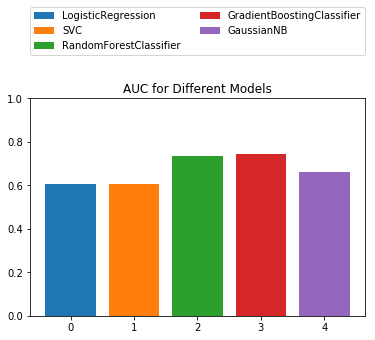

In [212]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['roc_auc'])
    plt.bar(i, model_results[model]['val']['roc_auc'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("AUC for Different Models")
plt.show()

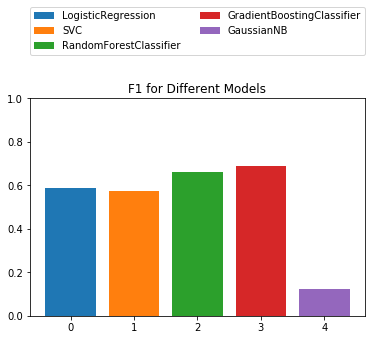

In [213]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['f1'])
    plt.bar(i, model_results[model]['val']['f1'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("F1 for Different Models")
plt.show()

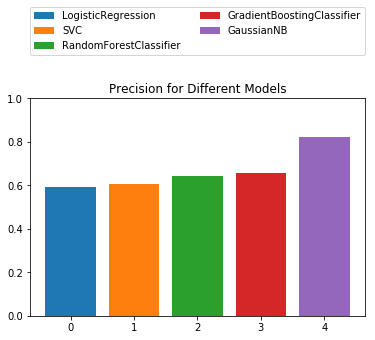

In [214]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['precision'])
    plt.bar(i, model_results[model]['val']['precision'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Precision for Different Models")
plt.show()

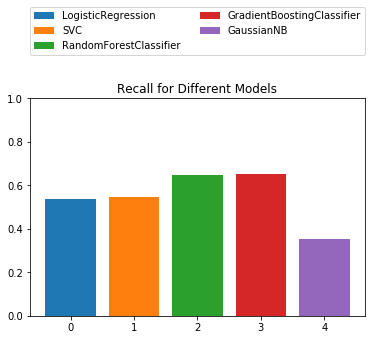

In [158]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['recall'])
    plt.bar(i, model_results[model]['val']['recall'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Recall for Different Models")
plt.show()

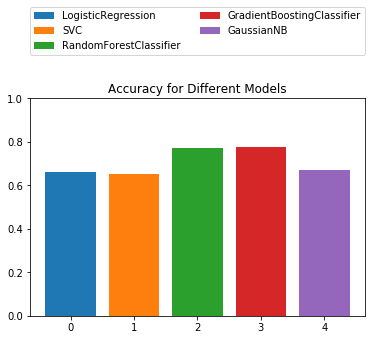

In [159]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['accuracy'])
    plt.bar(i, model_results[model]['val']['accuracy'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models")
plt.ylim([0,1])
plt.show()

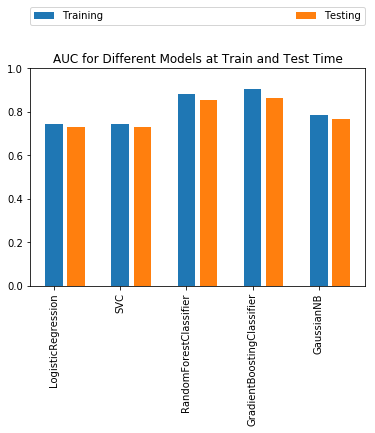

In [160]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

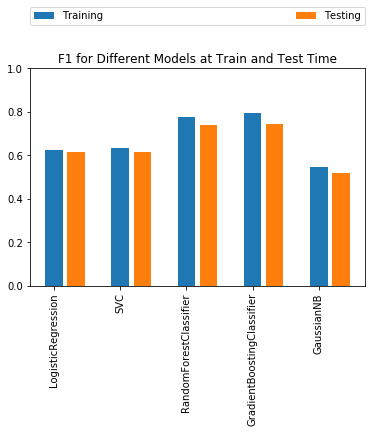

In [161]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

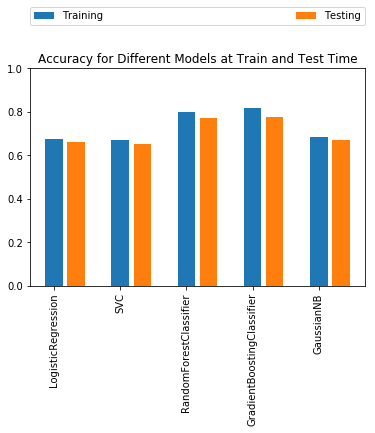

In [162]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

In [163]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('Random Forest',rfc),('Gradient Boosting',boost1)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['train']['accuracy'], model_results[model]['val']['accuracy'],
               model_results[model]['train']['roc_auc'], model_results[model]['val']['roc_auc'],
              model_results[model]['train']['f1'], model_results[model]['val']['f1'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Training Accuracy','Test Accuracy','Training Auc','Test Auc','Training F1','Test F1']

In [164]:
metrics_


,Training Accuracy,Test Accuracy,Training Auc,Test Auc,Training F1,Test F1
Logistic Regression,0.672566,0.660073,0.741493,0.729683,0.624423,0.613838
Random Forest,0.799142,0.769912,0.880171,0.854039,0.773236,0.739079
Gradient Boosting,0.815768,0.776158,0.902776,0.863120,0.791502,0.745261


In [165]:
# load future
f_nominal_sample = pd.read_csv('samples/2018_nominal_samples_n1.csv')
f_gray_sample = pd.read_csv('samples/2018_gray_samples_n1.csv')
f_failure_sample = pd.read_csv('samples/2018_failure_samples_n1.csv')

#clean future
f_nominal_sample = f_nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_failure_sample = f_failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample    = f_gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample.failure = 1
f_nominal_sample = f_nominal_sample.sample(frac=(f_failure_sample.shape[0]+f_gray_sample.shape[0])/f_nominal_sample.shape[0])

#create test set
data_curr = pd.concat([f_nominal_sample, f_gray_sample, f_failure_sample])
data_curr = data_curr.sample(frac=1)
f_y_test = data_curr['failure']

if scale=='sk':
    f_x_test = data_curr[feature_columns]
    f_x_test = scaler.transform(f_x_test)
elif scale=='manu_global':
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:    
        test_sub = data_curr[[i[:2].lower()==man.lower() for i in data_curr.model]]
        max_ = pd.read_csv('scaling/%s_max.csv' % man.lower())
        max_.index = max_['date']
        del max_['date']
        max_.columns = ['value']
        min_ = pd.read_csv('scaling/%s_min.csv' % man.lower())
        min_.index = min_['date']
        del min_['date']
        min_.columns = ['value']
        for col in feature_columns:
            range_ = float(max_.value[col]) - float(min_.value[col])
            if range_==0:
                range_ = 1
            test_sub[col] = (test_sub[col] - float(min_.value[col]))/range_
        test_norm = pd.concat([test_norm,test_sub])
        
    f_x_test = test_norm.sample(frac=1)[feature_columns]

    f_x_test = f_x_test.values




In [166]:
f_rate = 1             #1974/27342897
n_rate = 27340923/1974 #27340923/27342897
print(f_rate,n_rate)
f_sample_weights = compute_sample_weight({1:f_rate,0:n_rate},f_y_test)

1 13850.518237082068


In [167]:
for model in models:
    pred_test = model.predict_proba(f_x_test)[:,1]
    eval_f = helper.evaluation_metrics(pred_test, f_y_test)
    eval_f2 = helper.weighted_evaluation_metrics(pred_test, f_y_test, f_sample_weights)
    model_results[model]['future'] = eval_f
    model_results[model]['future2'] = eval_f2

In [168]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('Random Forest',rfc),('Gradient Boosting',boost1)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['val2']['accuracy'], model_results[model]['future2']['accuracy'],
               model_results[model]['val2']['roc_auc'], model_results[model]['future2']['roc_auc'],
              model_results[model]['val2']['f1'], model_results[model]['future2']['f1'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Weighted Test Accuracy','Weighted Future Accuracy','Weighted Test Auc','Weighted Future Auc','Weighted Test F1','Weighted Future F1']

In [169]:
metrics_

,Weighted Test Accuracy,Weighted Future Accuracy,Weighted Test Auc,Weighted Future Auc,Weighted Test F1,Weighted Future F1
Logistic Regression,0.783432,0.824510,0.729683,0.718558,0.000817,0.000405
Random Forest,0.892219,0.968913,0.854039,0.790558,0.001978,0.002484
Gradient Boosting,0.901633,0.950281,0.863120,0.788077,0.002177,0.001568


In [170]:
winsound.MessageBeep()

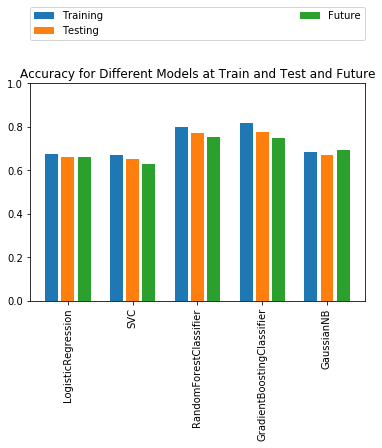

In [171]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
    data_f.append(model_results[model]['future']['accuracy'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

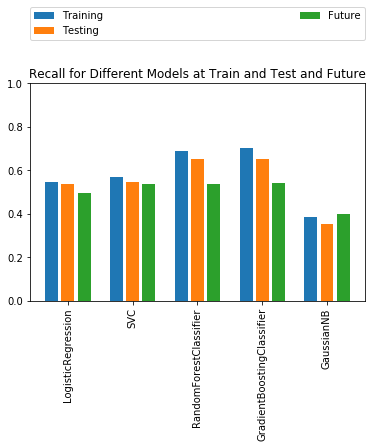

In [172]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['recall'])
    data_v.append(model_results[model]['val']['recall'])
    data_f.append(model_results[model]['future']['recall'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Recall for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [173]:
model_results[models[0]]['val']['confusion'],model_results[models[0]]['future']['confusion']

(array([[749, 207],
        [446, 519]], dtype=int64), array([[1593,  339],
        [ 980,  952]], dtype=int64))

In [174]:
model_results[models[1]]['val']['confusion'],model_results[models[1]]['future']['confusion']

(array([[726, 230],
        [437, 528]], dtype=int64), array([[1386,  546],
        [ 893, 1039]], dtype=int64))

In [175]:
model_results[models[2]]['val']['confusion'],model_results[models[2]]['future']['confusion']

(array([[853, 103],
        [339, 626]], dtype=int64), array([[1872,   60],
        [ 896, 1036]], dtype=int64))

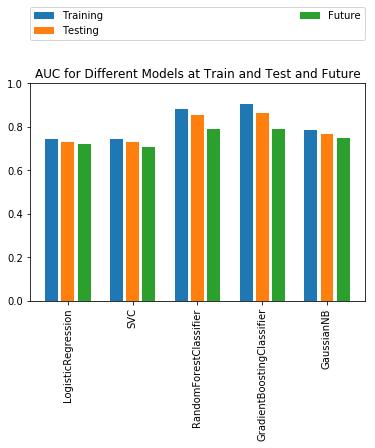

In [176]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
    data_f.append(model_results[model]['future']['roc_auc'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

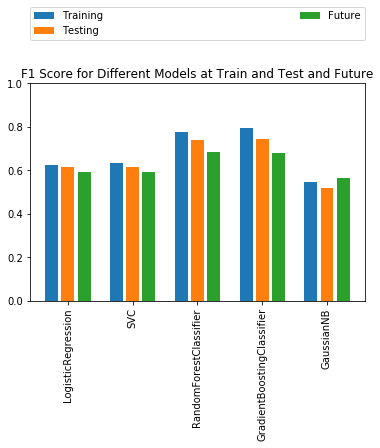

In [177]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
    data_f.append(model_results[model]['future']['f1'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 Score for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

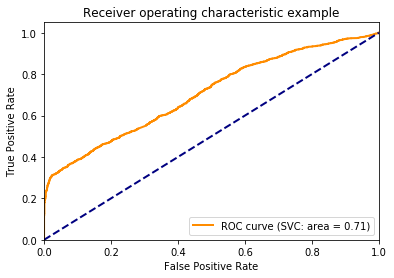

In [178]:
tpr = model_results[models[1]]['future']['tpr']
fpr = model_results[models[1]]['future']['fpr']
auc = model_results[models[1]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(models[1]).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

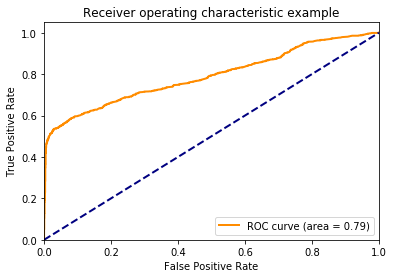

In [179]:
tpr = model_results[models[2]]['future']['tpr']
fpr = model_results[models[2]]['future']['fpr']
auc = model_results[models[2]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

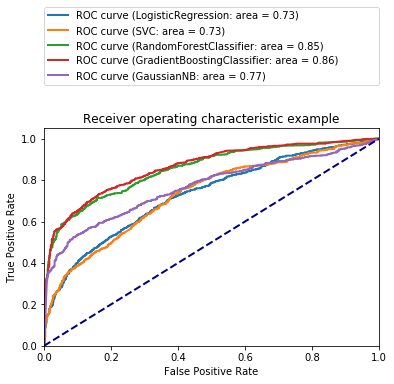

In [180]:
plt.figure()
lw = 2
for mod in models:
    tpr = model_results[mod]['val']['tpr']
    fpr = model_results[mod]['val']['fpr']
    auc = model_results[mod]['val']['roc_auc']
    plt.plot(fpr, tpr, 
             lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(mod).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

In [181]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score, f1_score


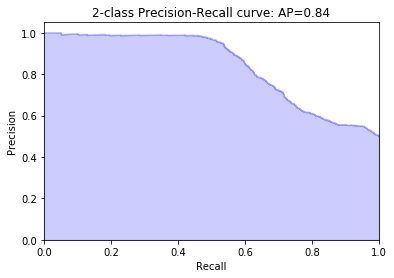

In [182]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
average_precision = average_precision_score(f_y_test, f_y_score)
precision, recall, _ = precision_recall_curve(f_y_test, f_y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [183]:
from sklearn.metrics import f1_score

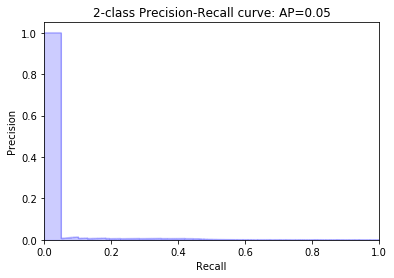

In [184]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
average_precision = average_precision_score(f_y_test, f_y_score, sample_weight=f_sample_weights)
precision, recall, _ = precision_recall_curve(f_y_test, f_y_score, sample_weight=f_sample_weights)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [185]:
from sklearn.metrics import roc_curve,auc,confusion_matrix

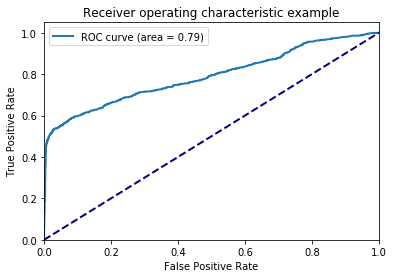

In [186]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
fpr, tpr, thresholds = roc_curve(f_y_test, f_y_score, sample_weight=f_sample_weights)
plt.plot(fpr, tpr, 
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend()
plt.show()

In [187]:
from sklearn.metrics import precision_score,recall_score,roc_curve

In [188]:
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        fpr,tpr,_ = roc_curve(f_y_test,f_y_score)
        print("AUC",auc(fpr,tpr))
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        ap = average_precision_score(f_y_test,f_y_score)
        print("AP",ap)
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        f1 = f1_score(f_y_test,1*(f_y_score>.5))
        print("F1",f1)

AUC 0.718557642023413
AUC 0.7051089260530929
AUC 0.7905584650369285
AUC 0.7880772346745882
AUC 0.7486249619570575
AP 0.7591155319498719
AP 0.7499637198736038
AP 0.841788881371995
AP 0.8367881939335873
AP 0.8011345930278783
F1 0.5907539559416692
F1 0.5908444697185101
F1 0.6842800528401587
F1 0.6801171493654409
F1 0.5643855776306107


In [189]:
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        fpr,tpr,_ = roc_curve(f_y_test,f_y_score,sample_weight=f_sample_weights)
        print("AUC",auc(fpr,tpr))
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        ap = average_precision_score(f_y_test,f_y_score,sample_weight=f_sample_weights)
        print("AP",ap)
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        f1 = f1_score(f_y_test,1*(f_y_score>.5),sample_weight=f_sample_weights)
        print("F1",f1)

AUC 0.7185576420234028
AUC 0.7051089260530822
AUC 0.7905584650369212
AUC 0.7880772346745806
AUC 0.7486249619570495
AP 0.0999547684654003
AP 0.1186769340706703
AP 0.05384015387046409
AP 0.10093917172515746
AP 0.0014987216851226988
F1 0.0004052607543559409
F1 0.0002746732025610696
F1 0.0024844151682510062
F1 0.0015683311165772865
F1 0.005769979145582781


In [190]:
for thres in (np.arange(0,1,.1)):
    print(thres)
    for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        #print(confusion_matrix(f_y_test,1*(f_y_score>thresh),sample_weight=f_sample_weights))
        print("Precision",precision_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))
        print("Recall",recall_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))
        print("F1",f1_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))

0.0
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
0.1
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.677701850571984e-05
Recall 0.9798136645962733
F1 0.00015354200564482912
Precision 0.002913664080999635
Recall 0.39803312629399584
F1 0.005784981204344527
0.2
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 8.147809296865354e-05
Recall 0.9720496894409938
F1 0.00016294252794576126
Precision 8.180760548921948e-05
Recall 0.9601449

In [191]:
thresh = .5
for model in models_plot:
    y_score = model.predict_proba(x_val)[:,-1]
    print(confusion_matrix(y_val,1*(y_score>thresh),sample_weight=val_sample_weights))
    print(precision_score(y_val,1*(y_score>thresh),sample_weight=val_sample_weights))
    print(recall_score(y_val,1*(y_score>thresh),sample_weight=val_sample_weights))

[[4.59113790e+06 1.26884586e+06]
 [4.46000000e+02 5.19000000e+02]]
0.00040886589660097354
0.5378238341968912
[[4.45015503e+06 1.40982873e+06]
 [4.37000000e+02 5.28000000e+02]]
0.00037437336891179207
0.5471502590673575
[[5.22862568e+06 6.31358083e+05]
 [3.39000000e+02 6.26000000e+02]]
0.00099053127579583
0.6487046632124353
[[5.28379289e+06 5.76190872e+05]
 [3.36000000e+02 6.29000000e+02]]
0.0010904617380535452
0.6518134715025907
[[5.78642748e+06 7.35562815e+04]
 [6.25000000e+02 3.40000000e+02]]
0.004601043422489447
0.35233160621761656


In [192]:
thresh = .5
for model in models_plot:
    y_score = model.predict_proba(x_val)[:,-1]
    tn, fp, fn, tp = (confusion_matrix(y_val,1*(y_score>thresh)).ravel())
    print(str(model).split('(')[0])
    print([tn, fp, fn, tp])
    print("Specificity",recall_score(y_val,1*(y_score>thresh),pos_label=0)) #specificity
    print("Sensitivity",recall_score(y_val,1*(y_score>thresh),pos_label=1)) #sensitivity
    print(tn/(tn+fp))
    print(tp/(fn+tp))
for model in models_plot:
    y_score = model.predict_proba(x_val)[:,-1]
    tn, fp, fn, tp = (confusion_matrix(y_val,1*(y_score>thresh),sample_weight=val_sample_weights).ravel())
    print(str(model).split('(')[0])
    print([tn, fp, fn, tp])
    print("Specificity",recall_score(y_val,1*(y_score>thresh),pos_label=0,sample_weight=val_sample_weights)) #specificity
    print("Sensitivity",recall_score(y_val,1*(y_score>thresh),pos_label=1,sample_weight=val_sample_weights)) #sensitivity
    print(tn/(tn+fp))
    print(tp/(fn+tp))

LogisticRegression
[749, 207, 446, 519]
Specificity 0.7834728033472803
Sensitivity 0.5378238341968912
0.7834728033472803
0.5378238341968912
SVC
[726, 230, 437, 528]
Specificity 0.7594142259414226
Sensitivity 0.5471502590673575
0.7594142259414226
0.5471502590673575
RandomForestClassifier
[853, 103, 339, 626]
Specificity 0.8922594142259415
Sensitivity 0.6487046632124353
0.8922594142259415
0.6487046632124353
GradientBoostingClassifier
[862, 94, 336, 629]
Specificity 0.9016736401673641
Sensitivity 0.6518134715025907
0.9016736401673641
0.6518134715025907
GaussianNB
[944, 12, 625, 340]
Specificity 0.9874476987447699
Sensitivity 0.35233160621761656
0.9874476987447699
0.35233160621761656
LogisticRegression
[4591137.904411712, 1268845.856092437, 446.0, 519.0]
Specificity 0.7834728033472828
Sensitivity 0.5378238341968912
0.7834728033472783
0.5378238341968912
SVC
[4450155.031512556, 1409828.7289915984, 437.0, 528.0]
Specificity 0.7594142259414253
Sensitivity 0.5471502590673575
0.7594142259414203


1428 failures / 17509251 total samples
Actually {} failures 2856
Out of {} 17509251
So {} non failures 17506395